In [9]:
import numpy as np
import pandas as pd
import os
import argparse
from tqdm import tqdm
import logging

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

import matplotlib.pyplot as plt

logging.basicConfig(level = logging.INFO)

In [10]:
class Dataset:
    def __init__(self, data_dir, dataset_name):
        
        self.path = os.path.join(data_dir, dataset_name)
        self.dataset_name = dataset_name
        
        if dataset_name is 'colon':
            self.gene_expression_values_file = "gene_values.txt"
            self.labels_file = "labels_for_each_tissue.txt"
        
        elif dataset_name is 'leukemia':
            self.scale_file = 'rescale_factors.txt'
            self.samples_file = "table_ALL_AML_samples.txt"
            self.train_file = "train.tsv"
            self.test_file = "test.tsv"
        
        self.read_data()
        self.transform_data()
            
    def read_data(self):
        
        logging.info("Reading Dataset %s", self.dataset_name)
        
        if self.dataset_name is 'colon':
            with open(os.path.join(self.path, self.gene_expression_values_file), 'r') as f:
                gene_expression_values = [line.strip() for line in tqdm(f.readlines())]
                expressions = []
                for gene in gene_expression_values:
                    if gene != '':
                        expression_values = np.array(gene.split(" "))
                        expressions.append(expression_values)

            with open(os.path.join(self.path, self.labels_file), 'r') as f:
                labels = [int(line.strip()) for line in tqdm(f.readlines())]
                labels = np.array(labels)
                labels[labels>0] = 1
                labels[labels<=0] = 0
                
            self.features = np.array(expressions, dtype=np.float64).T
            self.target = labels
            self.split_data(split_perc = 0.2)
            
        elif self.dataset_name is 'leukemia':
            with open(os.path.join(self.path, self.scale_file), "r") as f:
                x = f.readlines()
                x = [y.strip().split(" ") for y in x]
                scale_factors = [float(y[1]) for y in x]
                train_scale_factors = np.array(scale_factors[:38])
                test_scale_factors = np.array(scale_factors[38:])
                      
            with open(os.path.join(self.path, self.samples_file), "r") as f:
                x = f.readlines()
                labels = []
                for y in x:
                    yx = y.split("\t")
                    labels.append((1 if yx[2].strip() == 'ALL' else 0))
                self.Y_train = labels[:38]
                self.Y_test = labels[38:]
                      
            train_data = pd.read_csv(os.path.join(self.path, self.train_file), sep="\t")
            train_data = np.array(train_data).T
            self.X_train = train_data*train_scale_factors[:, np.newaxis]
               
            test_data = pd.read_csv(os.path.join(self.path, self.test_file), sep="\t")
            test_data = np.array(test_data).T
            self.X_test = test_data*test_scale_factors[:, np.newaxis]
            
            self.features = np.vstack((self.X_train, self.X_test))
            self.target = np.append(self.Y_train, self.Y_test)
            
        logging.info("Reading data completed. The train dataset size is %s", self.X_train.shape)
        
    def split_data(self, split_perc = 0.2):
        
        logging.info("Splitting the dataset into train and test sets with a split percentage of %s", split_perc)
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = \
        train_test_split(self.features, self.target, test_size = split_perc, random_state = 1405)
        
        logging.info("Splitting is completed. The dimensions of the train dataset are %s", self.X_train.shape)
        
    def transform_data(self):
        
        logging.info("Standardizing the data to have to zero mean and one variance")
        
        standard_scaler = StandardScaler()
        standard_scaler.fit(self.X_train)
        self.X_train = standard_scaler.transform(self.X_train)
        self.X_test = standard_scaler.transform(self.X_test)
        
        logging.info("Standardizing is completed.")

In [11]:
colon_data = Dataset("/home/avinash/UIUC/CS466/cancer-classification/Data", 'colon')

INFO:root:Reading Dataset colon
100%|██████████| 62/62 [00:00<00:00, 374707.27it/s]
INFO:root:Splitting the dataset into train and test sets with a split percentage of 0.2
INFO:root:Splitting is completed. The dimensions of the train dataset are (49, 2000)
INFO:root:Reading data completed. The train dataset size is (49, 2000)
INFO:root:Standardizing the data to have to zero mean and one variance
INFO:root:Standardizing is completed.


In [12]:
leukemia_data = Dataset("/home/avinash/UIUC/CS466/cancer-classification/Data", "leukemia")

INFO:root:Reading Dataset leukemia
INFO:root:Reading data completed. The train dataset size is (38, 7129)
INFO:root:Standardizing the data to have to zero mean and one variance
INFO:root:Standardizing is completed.


In [13]:
class ModelUtilities:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
    def get_important_features(self, method, number_of_features):
        if method is 'select_k_best':
            best_indices = SelectKBest(k=number_of_features, score_func=f_classif).fit(self.X_train, self.Y_train).get_support(indices=True)
            return best_indices
    
    def test_for_all(data):
        from collections import defaultdict
        scores = defaultdict(list)
        for nf in range(5, 51):
            for k in range(1, 21):
                best_features = self.get_important_features(self.X_train, self.Y_train, 'select_k_best', nf)
                tr_acc, test_acc = self.build_nearest_neighbor_model(self, k, best_features)
                scores[nf].append(test_acc)
        return scores

In [14]:
def get_kbest_features(X_train, Y_train, number_of_features):
    best_indices = SelectKBest(k=number_of_features, score_func=f_classif).fit(X_train, Y_train).get_support(indices=True)
    return best_indices

In [15]:
def build_nearest_neighbor_model(X_train, Y_train, k = 5, feature_indices = None):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, Y_train)

    return model

In [16]:
def build_svm_model(X_train, Y_train, feature_indices = None, kernel = 'rbf'):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]
        
    model = svm.SVC(C=1.0, kernel=kernel, gamma=0.01, random_state=1405)
    model.fit(X_train, Y_train)
    
    return model

In [17]:
def build_naive_bayes_model(X_train, Y_train, feature_indices = None):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]
        
    model = GaussianNB()
    model.fit(X_train, Y_train)
    
    return model

In [18]:
def build_random_forest_model(X_train, Y_train, feature_indices = None, n_trees = 20):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]
        
    model = RandomForestClassifier(n_estimators=n_trees)
    model.fit(X_train, Y_train)
    
    return model

In [59]:
def build_logistic_regression_model(X_train, Y_train, feature_indices = None):
    if feature_indices is not None:
        print("yes")
        X_train = X_train[:, feature_indices]
        
    print(X_train.shape)
    model = LogisticRegression(random_state=1405, solver='lbfgs')
    model.fit(X_train, Y_train)
    
    return model

In [60]:
def calculate_accuracies(X_train, Y_train, X_test, Y_test, model, feature_indices = None):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]
        X_test = X_test[:, feature_indices]

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)

    train_accuracy = metrics.accuracy_score(y_pred=train_pred_y, y_true=Y_train)
    test_accuracy = metrics.accuracy_score(y_pred=test_pred_y, y_true=Y_test)

    return train_accuracy, test_accuracy

In [61]:
def plot_roc_curve(X_train, Y_train, X_test, Y_test, model, feature_indices = None):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]
        X_test = X_test[:, feature_indices]

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(Y_test, test_pred_y)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [62]:
data = leukemia_data

In [68]:
best_features = get_kbest_features(data.X_train, data.Y_train, 1000)

In [69]:
# KNN
# model = build_nearest_neighbor_model(data.X_train, data.Y_train, feature_indices=best_features)
# calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)

# Naive Bayes
# model = build_naive_bayes_model(data.X_train, data.Y_train, feature_indices=best_features)
# calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)

# Logistic Regression
model = build_logistic_regression_model(data.X_train, data.Y_train, feature_indices=best_features)
calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)

# Logistic Regression
# model = build_svm_model(data.X_train, data.Y_train, feature_indices=best_features)
# calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)
#plot_roc_curve(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)

yes
(38, 1000)


(1.0, 1.0)

In [71]:
def perform_RFE(model, n_features, step, X_train, Y_train, best_features):
    feature_extractor = RFE(model, n_features, step)
    feature_extractor = feature_extractor.fit(X_train[:, best_features], Y_train)
    top_features = np.where(feature_extractor.ranking_ == 1)
    return top_features[0]

In [72]:
f = perform_RFE(model, 20, 10, data.X_train, data.Y_train, best_features)

In [73]:
f

array([ 64, 163, 232, 251, 264, 288, 304, 332, 342, 457, 465, 472, 535,
       592, 701, 720, 821, 873, 916, 932])

In [98]:
np.mean(cross_val_score(X=leukemia_data.features[:, best_features], estimator=model, cv=5, y=leukemia_data.target))

0.6523809523809524

In [30]:
def test_for_all_knn(data):
    from collections import defaultdict
    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    for nf in range(5, 51):
        for k in range(1, 21):
            best_features = get_kbest_features(data.X_train, data.Y_train, nf)
            model = build_nearest_neighbor_model(data.X_train, data.Y_train, k, best_features)
            train_acc, test_acc = calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)
            train_scores[nf].append(train_acc)
            test_scores[nf].append(test_acc)
    return train_scores, test_scores

In [49]:
def test_for_all_gnb(data):
    from collections import defaultdict
    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    for nf in range(40, 250, 20):
        best_features = get_kbest_features(data.X_train, data.Y_train, nf)
        model = build_naive_bayes_model(data.X_train, data.Y_train, feature_indices=best_features)
        train_acc, test_acc = calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)
        train_scores[1].append(train_acc)
        test_scores[1].append(test_acc)
    return train_scores, test_scores

In [301]:
def test_for_all_rf(data):
    from collections import defaultdict
    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    for nf in range(5, 51):
        best_features = get_kbest_features(data.X_train, data.Y_train, nf)
        model = build_random_forest_model(data.X_train, data.Y_train, feature_indices=best_features)
        train_acc, test_acc = calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)
        train_scores[1].append(train_acc)
        test_scores[1].append(test_acc)
    return train_scores, test_scores

In [62]:
def test_for_all_lr(data):
    from collections import defaultdict
    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    for nf in range(5, 51):
        best_features = get_kbest_features(data.X_train, data.Y_train, nf)
        model = build_logistic_regression_model(data.X_train, data.Y_train, feature_indices=best_features)
        train_acc, test_acc = calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)
        train_scores[1].append(train_acc)
        test_scores[1].append(test_acc)
    return train_scores, test_scores

In [99]:
def test_for_all_svm(data):
    from collections import defaultdict
    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    for nf in range(5, 51):
        best_features = get_kbest_features(data.X_train, data.Y_train, nf)
        model = build_svm_model(data.X_train, data.Y_train, feature_indices=best_features)
        train_acc, test_acc = calculate_accuracies(data.X_train, data.Y_train, data.X_test, data.Y_test, model, feature_indices=best_features)
        train_scores[1].append(train_acc)
        test_scores[1].append(test_acc)
    return train_scores, test_scores

In [100]:
# train_scores, test_scores = test_for_all_knn(data)
# train_scores, test_scores = test_for_all_gnb(data)
# train_scores, test_scores = test_for_all_rf(data)
train_scores, test_scores = test_for_all_svm(data)
# train_scores, test_scores = test_for_all_lr(data)

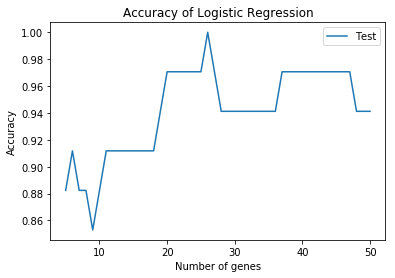

In [65]:
plt.figure()
# plt.plot(list(range(5, 51)), train_scores[1], label = "Train")
plt.plot(list(range(5, 51)), test_scores[1], label = "Test")
plt.title("Accuracy of Logistic Regression")
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

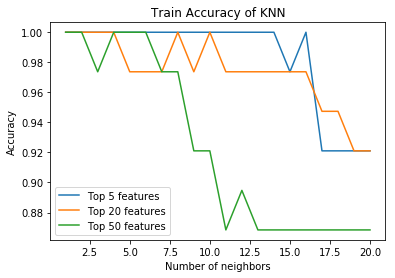

In [32]:
plt.figure()
plt.plot(list(range(1, 21)), train_scores[5], label = "Top 5 features")
plt.plot(list(range(1, 21)), train_scores[20], label = "Top 20 features")
plt.plot(list(range(1, 21)), train_scores[50], label = "Top 50 features")
plt.title("Train Accuracy of KNN")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

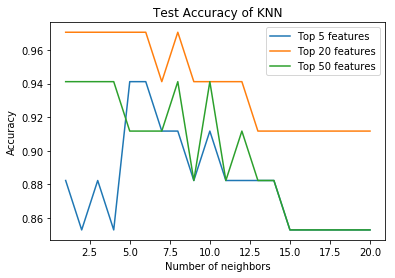

In [33]:
plt.figure()
plt.plot(list(range(1, 21)), test_scores[5], label = "Top 5 features")
plt.plot(list(range(1, 21)), test_scores[20], label = "Top 20 features")
plt.plot(list(range(1, 21)), test_scores[50], label = "Top 50 features")
plt.title("Test Accuracy of KNN")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

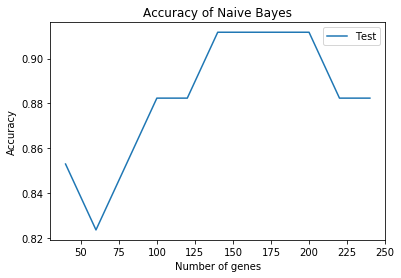

In [52]:
plt.figure()
# plt.plot(list(range(40, 250, 20)), train_scores[1], label = "Train")
plt.plot(list(range(40, 250, 20)), test_scores[1], label = "Test")
plt.title("Accuracy of Naive Bayes")
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

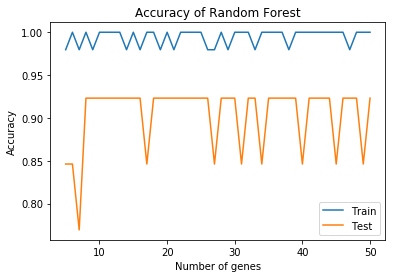

In [303]:
plt.figure()
plt.plot(list(range(5, 51)), train_scores[1], label = "Train")
plt.plot(list(range(5, 51)), test_scores[1], label = "Test")
plt.title("Accuracy of Random Forest")
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

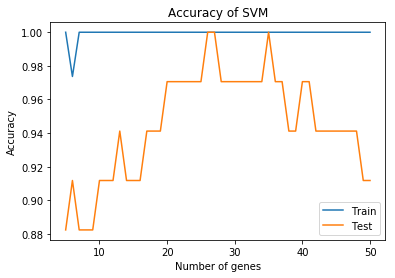

In [101]:
plt.figure()
plt.plot(list(range(5, 51)), train_scores[1], label = "Train")
plt.plot(list(range(5, 51)), test_scores[1], label = "Test")
plt.title("Accuracy of SVM")
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.legend()
plt.show()